In [126]:
import torch.nn
from torch.nn import MSELoss
from torch import nn
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from time import sleep

## Logistic regression

In [534]:
def plot_regression(x, y, title, preds=None):
    _ = plt.figure()
    plt.suptitle(title)
    plt.scatter(x, y)
    if preds is not None:
        plt.plot(x, preds)
    plt.show()

def generate_data(n):
    points = (np.random.random(n*2).reshape(-1, 2)-0.5)*4
    target = (points**2).sum(1) < 1
    return points, target

Data in the cirtcle with center in (0,0) and radius 1 has a label 1, outside 0.

In [535]:
N = 1000
points, labels = generate_data(N)

In [601]:
def plot_points(points, labels, title, ax=None):
    if ax == None:
        fig = plt.figure()
        fig.set_size_inches(8, 8)
        ax = fig.add_subplot()
    ax.set_title(title)
    ax.scatter(points[labels][:, 0], points[labels][:, 1])
    ax.scatter(points[np.logical_not(labels)][:, 0], points[np.logical_not(labels)][:, 1])
    ax.axis('equal')

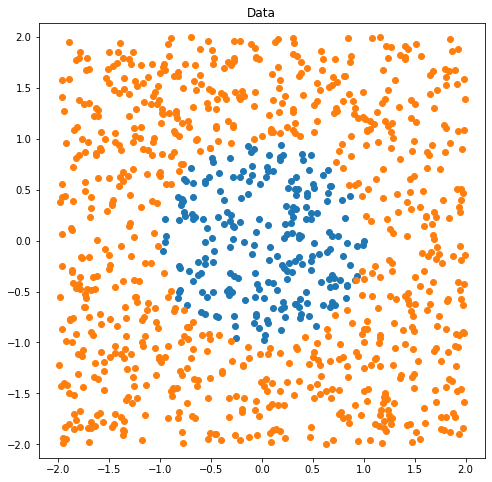

In [557]:
plot_points(points, labels, "Data")

What can we achieve with a single regressor?

In [901]:
net = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid(),
)

Our loss function will be MSE

In [902]:
criterion = MSELoss()

Define Adam optimizer and data tensors

In [903]:
optimizer = Adam(net.parameters(), lr=1e-1)
inputs = torch.tensor(points, dtype=torch.float32)
targets = torch.tensor(labels.reshape(N,1).astype(np.float32))

An epoch consists of
1. Calculating the mean loss.
2. Calling .backward() to calculate the derivatives with respect to loss.
3. optimizer.step()
4. Zero the derivatives to not accumulate them with the next epoch.

In [904]:
def run_epoch(net, optimizer):
    optimizer.zero_grad()
    output = net(inputs)
    loss = criterion(output, targets)
    loss.backward()
    optimizer.step()
    preds = (output>0.5).detach().cpu().numpy().reshape(N)
    return preds, loss.item()

In [905]:
epochs_data = [(i, run_epoch(net, optimizer)) for i in range(8)]

In [906]:
def plot_epochs(epochs_data, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for i, (epoch, (pred, loss)) in enumerate(epochs_data):
        plot_points(points, pred, f"After {epoch+1} epochs: loss={loss:.3f}", ax=ax[i//cols, i%cols] if rows>1 else ax[i])
    fig.set_size_inches(4*cols,4*rows)

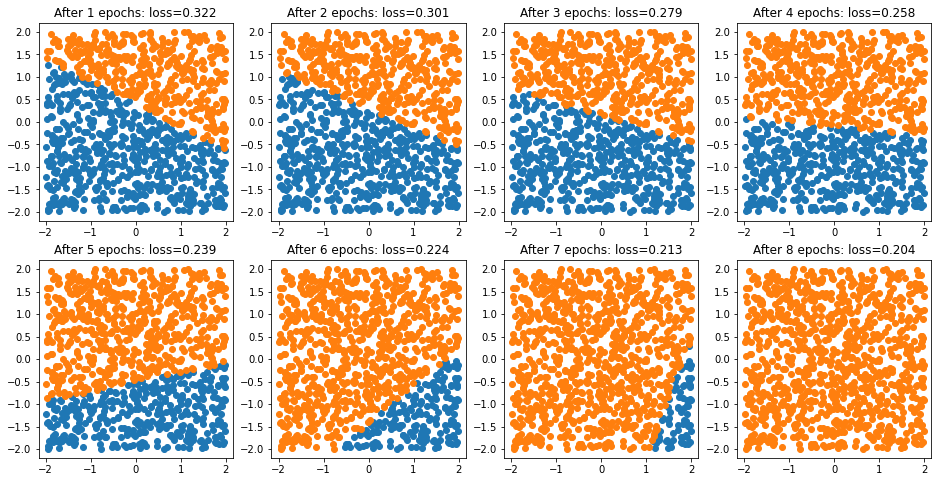

In [907]:
plot_epochs(epochs_data, 2, 4)

We see that a single classifier learns to classify everything as 0 and thus minimies the loss.
We increase the number of classifiers in the first layer of the net and add a second layer which summarizes their outputs.

In [908]:
def new_model(size, lr=1e-2):
    net = nn.Sequential(
        nn.Linear(2, size),
        nn.Sigmoid(),
        nn.Linear(size, 1),
        nn.Sigmoid(),
    )
    optimizer = Adam(net.parameters(), lr=lr)
    return net, optimizer

In [909]:
net, optimizer = new_model(3)

In [910]:
epochs_data = [(i, run_epoch(net, optimizer)) for i in range(8)]

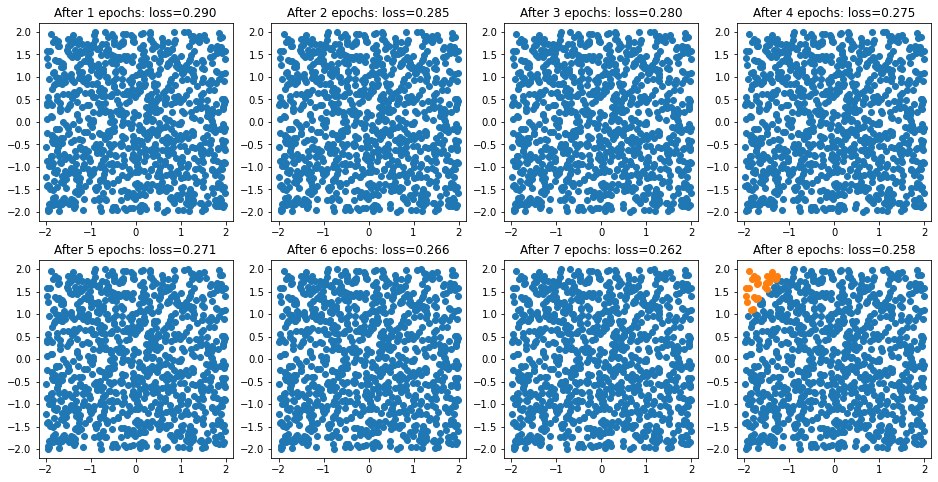

In [911]:
plot_epochs(epochs_data, 2, 4)

The model with 3 neurons doesn't learn so quickly. Fortunately data size is small so we can debug it by running a lot of epochs. Let's see how the loss behaves.

In [963]:
net, optimizer = new_model(3)
epochs_data = [(i, run_epoch(net, optimizer)) for _ in range(1000)]

In [964]:
def plot_loss(epochs_data):
    losses = [loss for _, (_, loss) in epochs_data]
    plt.plot(range(len(losses)), losses)
    plt.title("Loss")
    plt.show()

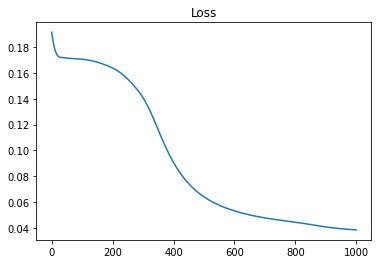

In [965]:
plot_loss(epochs_data)

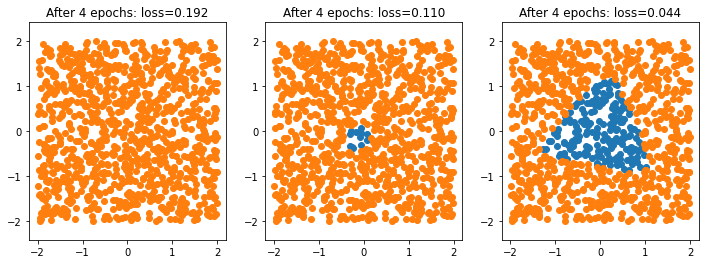

In [973]:
plot_epochs([epochs_data[i] for i in [0, 360, 800]], 1, 3)

We see that the big reductions of loss correspond to a new neuron doing something "meaningful".

Intuitively it seems very long, to take 1000 epochs to learn to classify the points in the triangle. We can speed it up by increasing the learning rate, to help our neurons "jump" over to something more meaningful instead of being stuck on some plateau.

In [984]:
net, optimizer = new_model(3, lr=1e-1)
epochs_data = [(i, run_epoch(net, optimizer)) for i in range(200)]

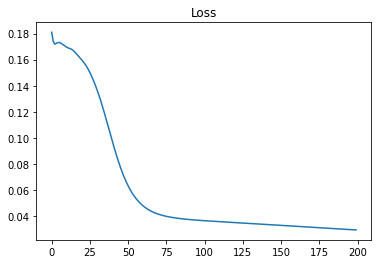

In [985]:
plot_loss(epochs_data)

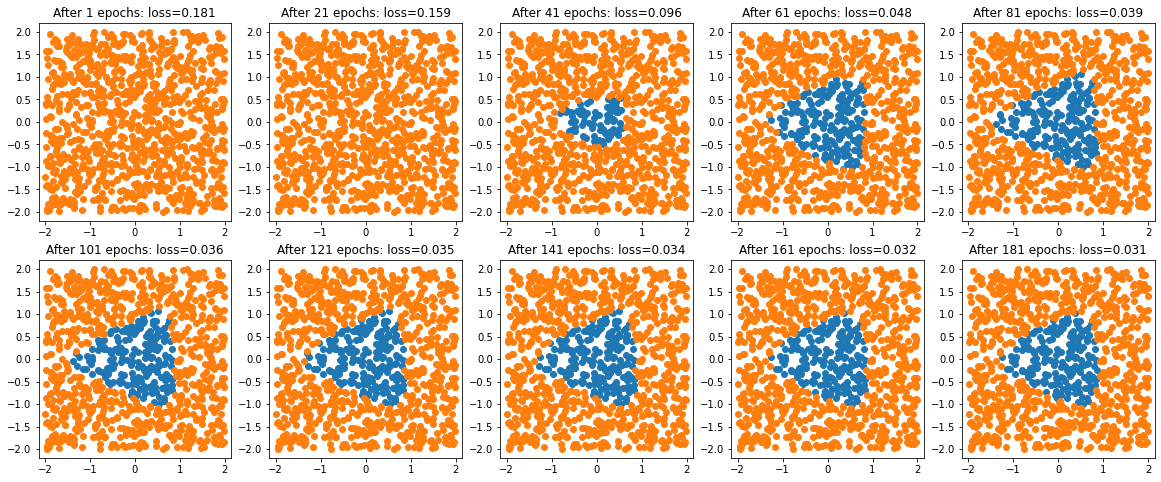

In [986]:
plot_epochs([epochs_data[i] for i in range(0, 200, 20)], 2, 5)

Another option might be to train the model in smaller batches, to make the training less stable.

In [987]:
def run_epoch_with_batches(net, optimizer, batch_size=50):
    optimizer.zero_grad()
    batches = N//batch_size
    indices = np.arange(N)
    loss_sum = 0.
    preds = (net(inputs)>0.5).detach().cpu().numpy().reshape(N)
    for _ in range(batches):
        batch_inds = np.random.choice(indices, size=batch_size)
        output = net(inputs[batch_inds])
        loss = criterion(output, targets[batch_inds])
        loss.backward()
        loss_sum += loss.item()
        optimizer.step()
    return preds, loss_sum/batches

In [988]:
net, optimizer = new_model(3)
epochs_data = [(i, run_epoch_with_batches(net, optimizer)) for i in range(200)]

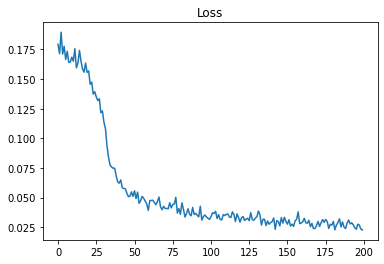

In [989]:
plot_loss(epochs_data)

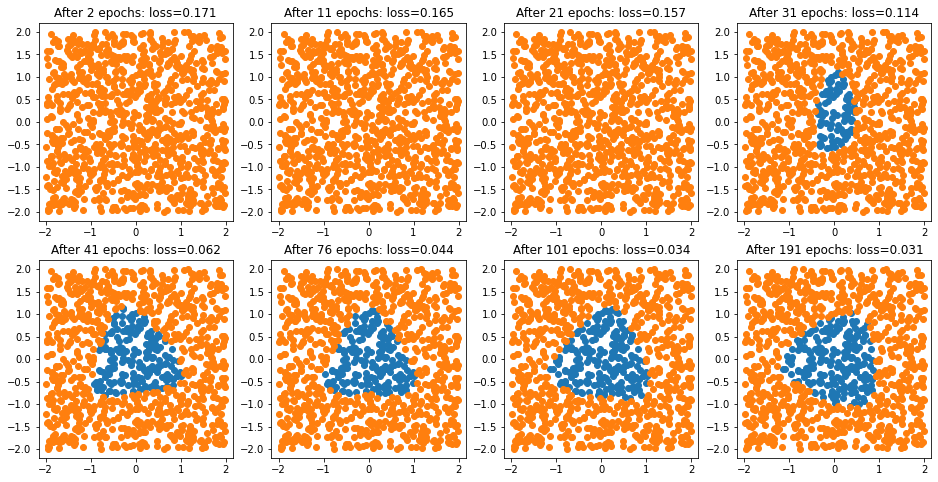

In [990]:
plot_epochs([epochs_data[i] for i in [1, 10, 20, 30, 40, 75, 100, 190]], 2, 4)

We see that the learning time reduced vastly. Let's now increase the number of neurons to 10, to make it possible to form a circle.

In [991]:
net, optimizer = new_model(size=10)
epochs_data = [(i, run_epoch_with_batches(net, optimizer)) for i in range(200)]

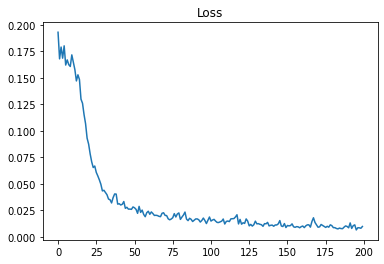

In [992]:
plot_loss(epochs_data)

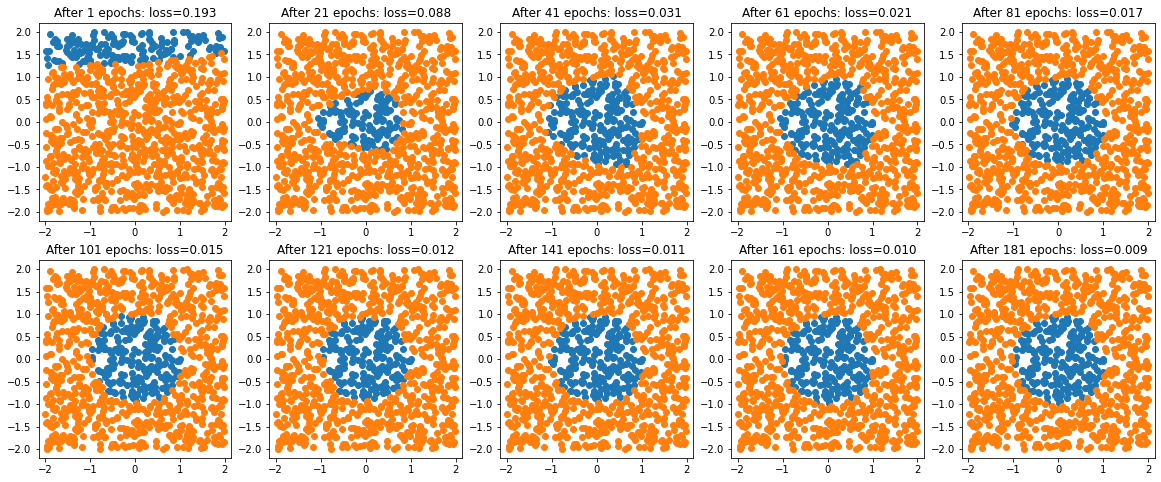

In [994]:
plot_epochs([epochs_data[i] for i in range(0, 200, 20)], 2, 5)

Now let's see what every single regressor is doing:

In [1024]:
modules = list(net.modules())
modules

[Sequential(
   (0): Linear(in_features=2, out_features=10, bias=True)
   (1): Sigmoid()
   (2): Linear(in_features=10, out_features=1, bias=True)
   (3): Sigmoid()
 ),
 Linear(in_features=2, out_features=10, bias=True),
 Sigmoid(),
 Linear(in_features=10, out_features=1, bias=True),
 Sigmoid()]

In [1026]:
linear = modules[1]

In [1034]:
preds = (torch.sigmoid(linear(inputs)) > 0.5).detach().cpu().numpy().transpose(1,0)

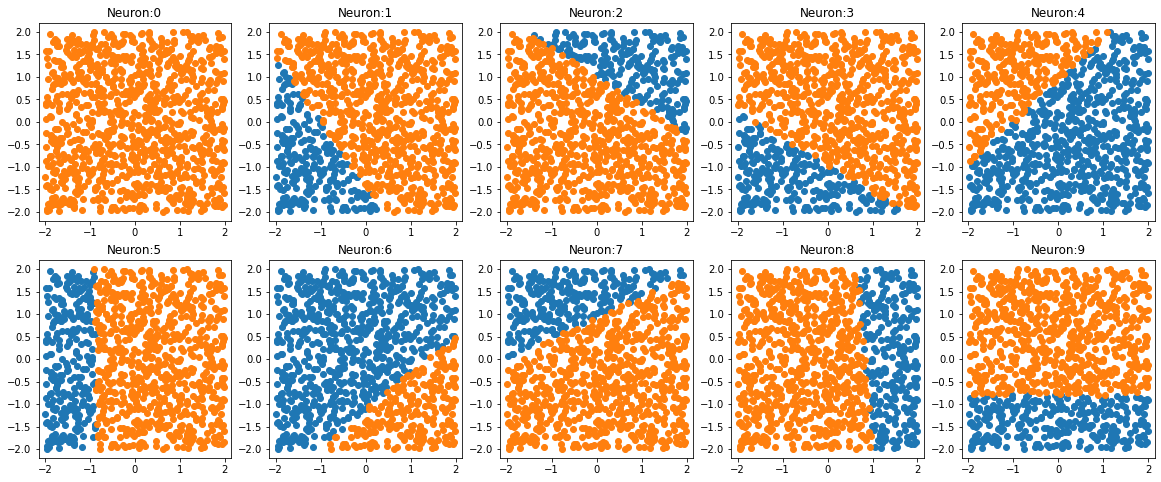

In [1038]:
fig, ax = plt.subplots(2, 5)
for i in range(10):
    plot_points(points, preds[i], f"Neuron:{i}", ax=ax[i//5, i%5])
fig.set_size_inches(20,8)

In [1042]:
next(modules[-2].parameters())

Parameter containing:
tensor([[ 0.2265, -4.5437, -6.0519, -2.0846,  1.5992, -5.8453,  4.8868, -8.4223,
         -7.2876, -6.2031]], requires_grad=True)

See that only the first neuron doesn't split the points into 2 classes, it's learned weights from the second layer is the smaller and this neuron contributes like an additional bias.